In [1]:
import gc # сборщик мусора
import datetime

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as img
import seaborn as sns
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_val_score

from lightgbm import LGBMRegressor

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.metrics import mean_squared_error as mse, r2_score as r2

from sklearn.preprocessing import StandardScaler, RobustScaler
%matplotlib inline

# Используемые функции

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
#                 elif

                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
def reduce_dims(df, dims=2, method='pca'):
    
    assert method in ['pca', 'tsne'], 'Неверно указан метод'
    
    if method=='pca':
        dim_reducer = PCA(n_components=dims, random_state=42)
        components = dim_reducer.fit_transform(df)
    elif method == 'tsne':
        dim_reducer = TSNE(n_components=dims, learning_rate=250, random_state=42)
        components = dim_reducer.fit_transform(df)
    else:
        print('Error')
        
    colnames = ['component_' + str(i) for i in range(1, dims+1)]
    return dim_reducer, pd.DataFrame(data = components, columns = colnames) 

In [4]:
def plot_feature_importances(importances, X):
    
    indices = np.argsort(importances)[::-1]

    plt.figure(figsize = (20, 6))
    plt.title("Feature importances", fontsize=16)
    plt.bar(range(X.shape[1]), importances[indices] / importances.sum(),
           color="darkblue", align="center")
    plt.xticks(range(X.shape[1]), X.columns[indices], rotation = 90, fontsize=14)
    plt.xlim([-1, X.shape[1]])

    plt.tight_layout()
    # plt.savefig('fe.jpg')
    plt.show()

# Загрузка данных

In [5]:
df = pd.read_csv('../../kaggle/realestatepriceprediction/train.csv')

X = df.drop('Price', axis=1)
y = df[['Id', 'Price']]

X_final = pd.read_csv('../../kaggle/realestatepriceprediction/test.csv')

X.set_index('Id', inplace=True)
X_final.set_index('Id', inplace=True)
y.set_index('Id', inplace=True)

print('Строк в трейне:' ,  X.shape[0])
print('Строк в тесте', X_final.shape[0])

# Удалим ненужные файлы
del df
gc.collect()  

Строк в трейне: 10000
Строк в тесте 5000


15

In [6]:
final_index_list = X_final.index

In [7]:
X = reduce_mem_usage(X)

Memory usage of dataframe is 1.45 MB
Memory usage after optimization is: 0.51 MB
Decreased by 65.1%


In [8]:
X_final = reduce_mem_usage(X_final)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.24 MB
Decreased by 66.4%


# Очистка данных

In [9]:
# одно единственное эффективное удаление выбросов

index_list = X[X['Square'] > 300].index
X = X.drop(index_list)
y = y.drop(index_list)

In [12]:
class FeatureImputer:
    """Заполнение пропусков и облработка выбросов"""
    
    def __init__(self):
        self.medians=None

    def fit(self, X):
        self.medians = X.median()
    
    def transform(self, X):
        
        # Rooms
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] = X.loc[X['KitchenSquare'] > 1000, 'KitchenSquare'] / 10
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
        X.loc[X['Floor'] > X['HouseFloor'], 'Floor'] = X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor']
        
        # HouseYear
        current_year = now = datetime.datetime.now().year
        
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year
        
        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        
        condition = (X['LifeSquare'].isna()) &\
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[X['LifeSquare_nan'] == 1, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 1
        
        # X['LifeSquare'] + X['KitchenSquare'] < X['Square']
        X['SqSum_outliner'] = 0
        X.loc[(X['LifeSquare'] + X['KitchenSquare'] < X['Square'] - 20), 'SqSum_outliner'] = 1
        X.loc[X['SqSum_outliner'] == 1, 'LifeSquare'] = X.loc[X['SqSum_outliner'] == 1, 'Rooms']*17.5
        
        X['SqSum2_outliner'] = 0
        X.loc[(X['LifeSquare'] + X['KitchenSquare'] < X['Square'] - 20), 'SqSum2_outliner'] = 1
        X.loc[X['SqSum2_outliner'] == 1, 'LifeSquare'] = X.loc[X['SqSum2_outliner'] == 1, 'Square'] - X.loc[X['SqSum2_outliner'] == 1, 'KitchenSquare'] - 1
        
        
        return X
    

In [13]:
imputer = FeatureImputer()

imputer.fit(X)

X = imputer.transform(X)

X_final = imputer.transform(X_final)

# Добавляем признаки

In [14]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.med_price_by_district = None
        
    def fit(self, X, y=None):
        
        X = X.copy()
        
        # DistrictID
        district = X['DistrictId'].value_counts()
        district = district[district > 40]
        
        self.DistrictId_counts = dict(district)
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # Target encoding
        ## District
        df = X.copy()
        
        if y is not None:
            df['Price'] = y.values
            
            df['DistrictId_popular'] = df['DistrictId'].copy()
            df.loc[~df['DistrictId_popular'].isin(district.keys().tolist())] = np.nan
            
            self.med_price_by_district = df.groupby(['DistrictId_popular', 'Rooms'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByDistrict',
                                                           'DistrictId_popular': 'DistrictId'})
            
        ## floor, year
        if y is not None:
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
            self.med_price_by_floor_year = df.groupby(['year_cat', 'floor_cat'], as_index=False).agg({'Price':'median'}).\
                                            rename(columns={'Price':'MedPriceByFloorYear'})
            
        ## square
        if y is not None:
            df['Price'] = y.values
            df = self.square_to_cat(df)
            self.med_price_by_square = df.groupby(['sq_cat'], as_index = False).agg({'Price':'median'}).\
                                        rename(columns={'Price':'MedPriceBySq'})
        
    def transform(self, X):
        
        # DistrictId
        X['DistrictId_count'] = X['DistrictId'].map(self.DistrictId_counts)
        
        X['new_district'] = 0
        X.loc[X['DistrictId_count'].isna(), 'new_district'] = 1
        
        X['DistrictId_count'].fillna(5, inplace=True)
        
        
        # More categorical features
        X = self.floor_to_cat(X)
        X = self.year_to_cat(X) 
        X = self.square_to_cat(X)
        
        # Target encoding
        if self.med_price_by_district is not None:
            X = X.merge(self.med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
        if self.med_price_by_floor_year is not None:
            X = X.merge(self.med_price_by_floor_year, on=['year_cat', 'floor_cat'], how='left')
        if self.med_price_by_square is not None:
            X = X.merge(self.med_price_by_square, on=['sq_cat'], how='left')
            
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)
        X['Ecology_2'] = X['Ecology_2'].astype('int8')
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Ecology_3'] = X['Ecology_3'].astype('int8')
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].astype('int8')
        X['Comb_eco2_eco3_shop2'] = X['Ecology_2'] + X['Ecology_3'] + X['Shops_2']
        
        return X
    
    @staticmethod
    def floor_to_cat(X):
        
        X['floor_cat'] = np.nan
        
        X.loc[X['Floor'] < 3, 'floor_cat'] = 1  
        X.loc[(X['Floor'] >= 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
        X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
        X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
        X.loc[X['Floor'] > 15, 'floor_cat'] = 5
            
        return X
     
    @staticmethod
    def year_to_cat(X):
        
        X['year_cat'] = np.nan
        
        X.loc[X['HouseYear'] < 1941, 'year_cat'] = 1
        X.loc[(X['HouseYear'] >= 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
        X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
        X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
        X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
        X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6
            
        return X
    
    @staticmethod
    def square_to_cat(X):
        X['sq_cat'] = np.nan
        
        X.loc[X['Square'] < 25, 'sq_cat'] = 1
        X.loc[(X['Square'] >= 25) & (X['Square'] < 40), 'sq_cat'] = 2
        X.loc[(X['Square'] >= 40) & (X['Square'] < 50), 'sq_cat'] = 5
        X.loc[(X['Square'] >= 50) & (X['Square'] < 60), 'sq_cat'] = 6
        X.loc[(X['Square'] >= 60) & (X['Square'] < 70), 'sq_cat'] = 3
        X.loc[(X['Square'] >= 70) & (X['Square'] < 80), 'sq_cat'] = 4
        X.loc[(X['Square'] >= 80) & (X['Square'] < 100), 'sq_cat'] = 5
        X.loc[(X['Square'] >= 100) & (X['Square'] < 126), 'sq_cat'] = 6
        X.loc[(X['Square'] >= 125), 'sq_cat'] = 7
        
        return X

In [15]:
features = FeatureGenetator()

features.fit(X, y)

X = features.transform(X)
X_final = features.transform(X_final)

In [16]:
# отдельно работаем с PCA

scaler = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(25.0, 75.0))

sub_fr = X[['Social_1','Social_2']].copy()
sub_fr_final = X_final[['Social_1','Social_2']].copy()

colnames = sub_fr.columns
sf_train_scaled = pd.DataFrame(scaler.fit_transform(sub_fr), columns=colnames)
sf_test_scaled = pd.DataFrame(scaler.transform(sub_fr_final), columns=colnames) # НЕ обучаемся на тесте!

dim_reducer1d, components_1d = reduce_dims(sf_train_scaled, dims=1, method='pca')

comp_1d_final = dim_reducer1d.transform(sf_test_scaled)

X['comp_1'] = components_1d['component_1']
X_final['comp_1'] = comp_1d_final

# Построение модели

In [17]:
drop_features = ['floor_cat', 'year_cat', 'Ecology_3', 'Ecology_2', 'Social_1', 'Social_2']
X = X.drop(drop_features, axis = 1)
X_final = X_final.drop(drop_features, axis=1)
X.columns

Index(['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor',
       'HouseFloor', 'HouseYear', 'Ecology_1', 'Social_3', 'Helthcare_2',
       'Shops_1', 'Shops_2', 'Rooms_outlier', 'HouseFloor_outlier',
       'HouseYear_outlier', 'LifeSquare_nan', 'SqSum_outliner',
       'SqSum2_outliner', 'DistrictId_count', 'new_district', 'sq_cat',
       'MedPriceByDistrict', 'MedPriceByFloorYear', 'MedPriceBySq',
       'Comb_eco2_eco3_shop2', 'comp_1'],
      dtype='object')

In [ ]:
# используем для оптимизации
lgb_model = LGBMRegressor(criterion='mse',
                            min_samples_leaf=10,
                            random_state=42                      
                         )

params = {'n_estimators':range(100, 350, 10), 
          'max_depth':range(3, 20, 2)}

gs = GridSearchCV(lgb_model, params, 
                  scoring='r2',
                  cv=KFold(n_splits=5,   
                           random_state=42, 
                           shuffle=True), 
                  n_jobs=-1  
                 )
gs.fit(X, y) 

In [ ]:
gs.best_params_

In [18]:
model = LGBMRegressor(max_depth=7,
                             min_samples_leaf=10,
                             n_estimators=210,
                             random_state=42)

cv_score = cross_val_score(model, X, y, 
                           scoring='r2', 
                           cv=KFold(n_splits=5, shuffle=True, random_state=42))
# cv_score
mean = cv_score.mean()
std = cv_score.std()

print('R2: {:.3f} +- {:.3f}'.format(mean, std))

R2: 0.755 +- 0.020


In [19]:
model.fit(X, y)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=7,
              min_child_samples=20, min_child_weight=0.001, min_samples_leaf=10,
              min_split_gain=0.0, n_estimators=210, n_jobs=-1, num_leaves=31,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

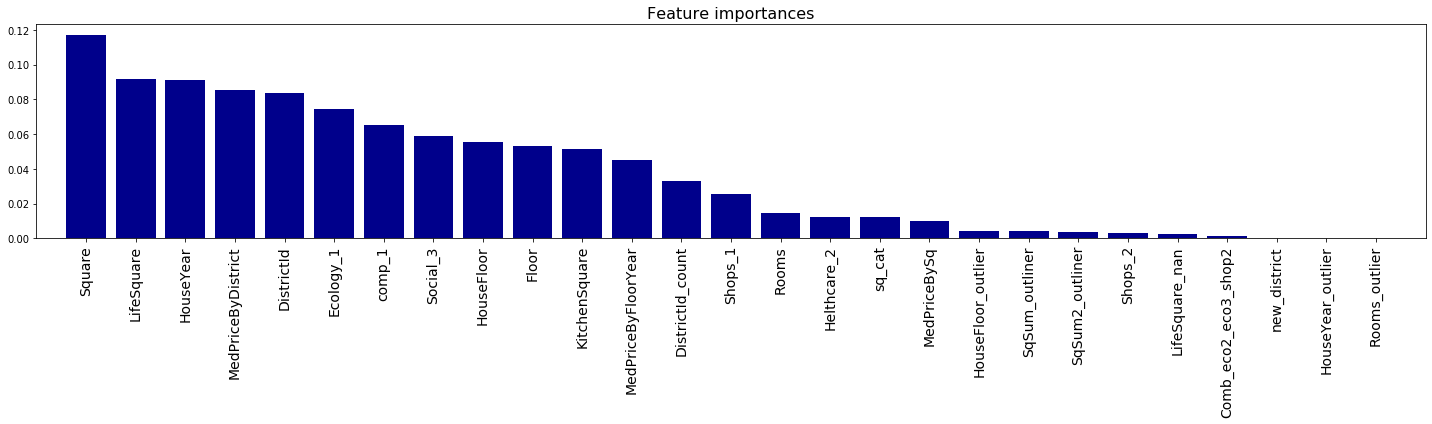

In [20]:
plot_feature_importances(importances = model.feature_importances_, X=X)

In [ ]:
y_pred_final = model.predict(X_final)

preds_final = pd.DataFrame()
preds_final['Id'] = final_index_list
preds_final['Price'] = y_pred_final
preds_final.to_csv('predictions.csv', index=False)

preds_final.head()